In [ ]:
!pip install pennylane

!pip install torch

!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/21

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 1. Preparar el conjunto de datos MNIST
# Descargar y normalizar
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # Normalizaci´on a [-1, 1]
    transforms.Resize((8, 8)) # Reducir a 8x8
])

train_dataset = datasets.MNIST(root="./mnist", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./mnist", train=False, transform=transform, download=True)

# Crear DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Configuración del dispositivo cuántico
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

# Definir circuito cuántico como QNode
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

weight_shapes = {"weights": (4, n_qubits)}  # Incrementamos a 4 capas en la red cuántica

# Crear capa cuántica para PyTorch
qml_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# Crear el modelo híbrido cuántico-clásico
class QuantumHybridModel(nn.Module):
    def __init__(self):
        super(QuantumHybridModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64, n_qubits)  # Entrada a la capa cuántica (64 píxeles -> n_qubits)
        self.q_layer = qml_layer  # Capa cuántica
        self.fc2 = nn.Linear(n_qubits, 10)  # Salida para 10 clases (dígitos 0-9)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.q_layer(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

# Crear instancia del modelo
model = QuantumHybridModel()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)  # Asegurar que las imágenes tengan forma (batch_size, 64)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

#train_model(model, train_loader, criterion, optimizer)

# Evaluar el modelo en el conjunto de prueba
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)  # Asegurar que las imágenes tengan forma (batch_size, 64)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Precisión en el conjunto de prueba: {100 * correct / total:.2f}%")

#evaluate_model(model, test_loader)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.4MB/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.95MB/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.63MB/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Precisión en el conjunto de prueba: 9.82%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/10, Loss: 2.0579
Epoch 2/10, Loss: 1.8651
Epoch 3/10, Loss: 1.8171
Epoch 4/10, Loss: 1.7731
Epoch 5/10, Loss: 1.7244
Epoch 6/10, Loss: 1.6884
Epoch 7/10, Loss: 1.6617
Epoch 8/10, Loss: 1.6505
Epoch 9/10, Loss: 1.6429
Epoch 10/10, Loss: 1.6375
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%
Precisión en el conjunto de prueba: 86.44%


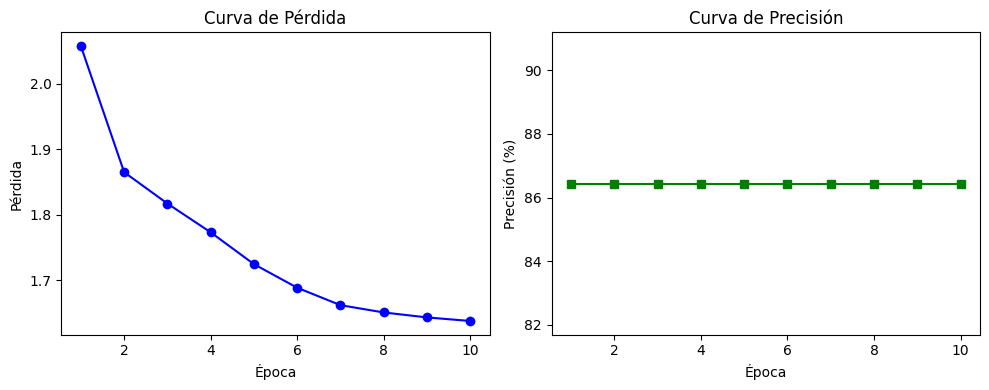

In [ ]:
import matplotlib.pyplot as plt

# Listas para almacenar la pérdida y precisión en cada época
epochs = 10  # Número de épocas
train_losses = []
test_accuracies = []

# Modificar la función de entrenamiento para registrar la pérdida
def train_model_with_tracking(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)  # Asegurar que las imágenes tengan forma (batch_size, 64)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Modificar la función de evaluación para registrar la precisión
def evaluate_model_with_tracking(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)  # Asegurar que las imágenes tengan forma (batch_size, 64)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")

# Entrenar el modelo con seguimiento de pérdida
train_model_with_tracking(model, train_loader, criterion, optimizer, epochs)

torch.save(model.state_dict(), "/content/drive/MyDrive/modelo_cuántico_híbrido.pth")

# Evaluar el modelo después de cada época
for _ in range(epochs):
    evaluate_model_with_tracking(model, test_loader)

# Graficar la curva de pérdida
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida')

# Graficar la curva de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, marker='s', linestyle='-', color='g')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Curva de Precisión')

plt.tight_layout()
plt.show()

# Nueva versión

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- CARGA DE DATOS ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((12, 12)),  # Imágenes 12x12
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./mnist", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./mnist", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- CONFIGURACIÓN DEL DISPOSITIVO CUÁNTICO ---
n_qubits = 12  # Número de qubits ajustado
dev = qml.device("lightning.qubit", wires=n_qubits)

# --- CIRCUITO CUÁNTICO ---
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (4, n_qubits)}
qml_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# --- MODELO HÍBRIDO CNN-QUÁNTICO ---
class QuantumCNN(nn.Module):
    def __init__(self):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # 🔹 CAMBIO: Ajustamos la capa `fc1` para recibir correctamente la salida de `conv2`
        self.fc1 = nn.Linear(32 * 3 * 3, n_qubits)  # AHORA CORRECTO ✅

        self.q_layer = qml_layer
        self.fc2 = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.q_layer(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

# --- ENTRENAMIENTO ---
model = QuantumCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses = []
test_accuracies = []

def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Época {epoch+1}/{epochs}, Pérdida: {avg_loss:.4f}")

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Precisión en prueba: {accuracy:.2f}%")

# --- EJECUCIÓN ---
for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, 1)
    evaluate(model, test_loader)

Época 1/1, Pérdida: 1.9743
Precisión en prueba: 76.75%
Época 1/1, Pérdida: 1.6978
Precisión en prueba: 94.13%
Época 1/1, Pérdida: 1.5679
Precisión en prueba: 96.10%
Época 1/1, Pérdida: 1.5289
Precisión en prueba: 96.63%
Época 1/1, Pérdida: 1.5141
Precisión en prueba: 96.82%


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/modelo_cnn_cuántico.pth'

In [11]:
# --- GUARDAR EL MODELO ---
torch.save(model.state_dict(), "/content/drive/MyDrive/modelo_cnn_cuántico.pth")
print("Modelo guardado correctamente en Google Drive.")

Modelo guardado correctamente en Google Drive.


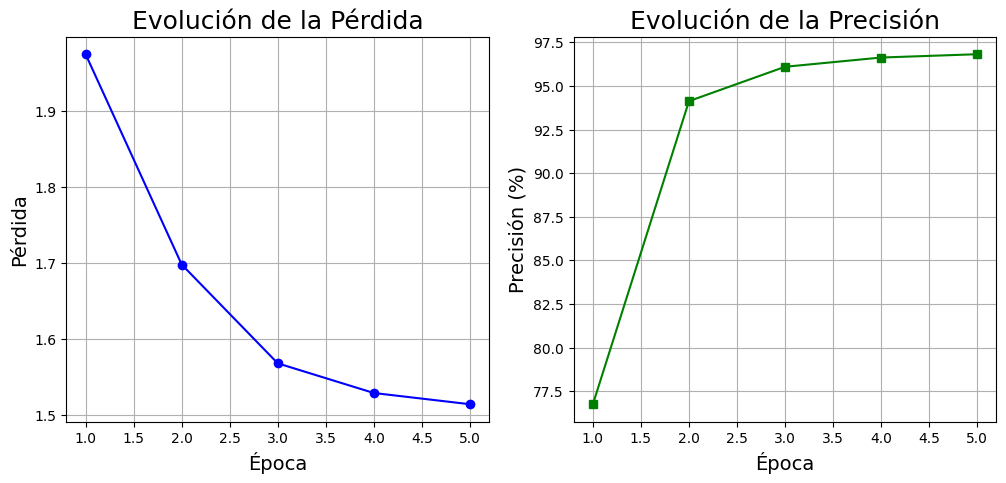

In [12]:
# --- VISUALIZACIÓN ---
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker="o", linestyle="-", color="b")
plt.xlabel("Época", fontsize=14)
plt.ylabel("Pérdida", fontsize=14)
plt.title("Evolución de la Pérdida", fontsize=18)
plt.grid()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, marker="s", linestyle="-", color="g")
plt.xlabel("Época", fontsize=14)
plt.ylabel("Precisión (%)", fontsize=14)
plt.title("Evolución de la Precisión", fontsize=18)
plt.grid()

plt.show()

In [6]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- CARGA DE DATOS ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((12, 12)),  # Imágenes 12x12
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./mnist", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./mnist", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- CONFIGURACIÓN DEL DISPOSITIVO CUÁNTICO ---
n_qubits = 12  # Número de qubits ajustado
dev = qml.device("lightning.qubit", wires=n_qubits)

# --- CIRCUITO CUÁNTICO ---
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (4, n_qubits)}
qml_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# --- MODELO HÍBRIDO CNN-QUÁNTICO ---
class QuantumCNN(nn.Module):
    def __init__(self):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # 🔹 CAMBIO: Ajustamos la capa `fc1` para recibir correctamente la salida de `conv2`
        self.fc1 = nn.Linear(32 * 3 * 3, n_qubits)  # AHORA CORRECTO ✅

        self.q_layer = qml_layer
        self.fc2 = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.q_layer(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)

# --- ENTRENAMIENTO ---
model = QuantumCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses = []
test_accuracies = []

def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Época {epoch+1}/{epochs}, Pérdida: {avg_loss:.4f}")

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Precisión en prueba: {accuracy:.2f}%")

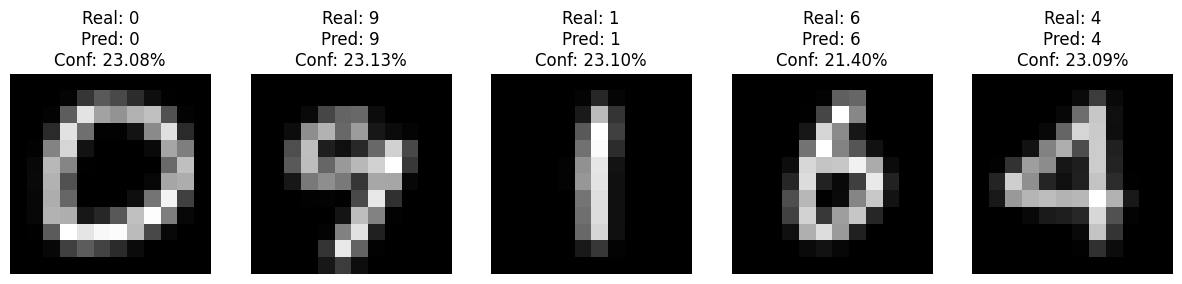

In [14]:
import random
import matplotlib.pyplot as plt
import torch

# Seleccionar 5 imágenes aleatorias del conjunto de prueba
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)
samples = [test_dataset[i] for i in indices]

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

model.eval()  # Activar modo evaluación
with torch.no_grad():
    for i, (image, label) in enumerate(samples):
        img_tensor = image.unsqueeze(0)  # Agregar dimensión batch
        output = model(img_tensor)  # Pasar por el modelo
        probas = torch.softmax(output, dim=1)  # Obtener probabilidades
        pred = torch.argmax(probas).item()  # Predicción
        confidence = torch.max(probas).item() * 100  # Confianza en %

        # Mostrar imagen con títulos mejorados
        axes[i].imshow(image.squeeze(), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Real: {label}\nPred: {pred}\nConf: {confidence:.2f}%", fontsize=12)

plt.show()

In [7]:
import torch

# --- GUARDAR EL MODELO ---
torch.save(model.state_dict(), "/content/drive/MyDrive/modelo_cnn_cuántico.pth")
print("Modelo guardado correctamente en Google Drive.")

# --- CARGAR EL MODELO (en otra sesión) ---
# Asegurar que la arquitectura del modelo está definida antes de cargar los parámetros
model = QuantumCNN()  # Crear una nueva instancia del modelo

# Cargar los parámetros guardados
model.load_state_dict(torch.load("/content/drive/MyDrive/modelo_cnn_cuántico.pth"))

# Poner el modelo en modo evaluación (importante para predicciones)
model.eval()
print("Modelo cargado correctamente desde Google Drive.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/modelo_cnn_cuántico.pth'